<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [3.1 Case Study: Thermal Cycling for PCR](https://jckantor.github.io/cbe30338-2021/03.01-Case-Study-Thermal-Cycling-PCR.html) | [Contents](toc.html) | [3.3 PID Control](https://jckantor.github.io/cbe30338-2021/03.03-PID_Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.02-Relay-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.02-Relay-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.2 Relay Control

## 3.2.1 Simple Relay Control

The following code implements relay control for temperature T1 on the Temperature Control Lab.

\begin{align}
Q(t) & = \begin{cases} 
    Q^{max} &\text{if $T \leq T_{setpoint}$}\\
    0       & \text{if $T \geq T_{setpoint}$}
    \end{cases}
\end{align}

This is simple to implement, in fact it is just one line of code in the following cell. Adjust `Tsetpoint` to a desired setpoint value, then run the cell.

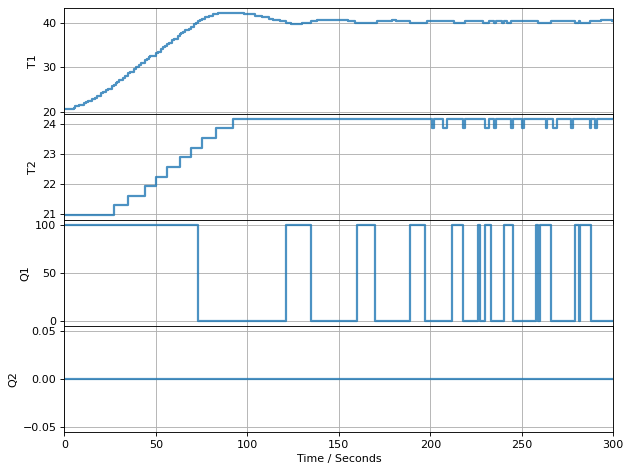

TCLab Model disconnected successfully.


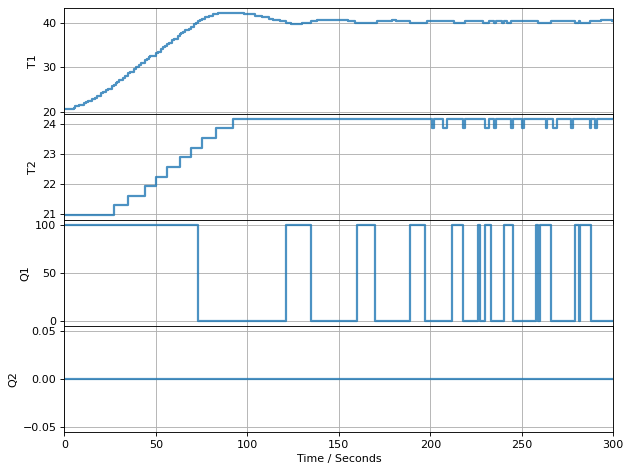

In [3]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
Qmax = 100
Tsetpoint = 40

# time horizon and time step
tfinal = 300
tstep = 1

# perform experiment
with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h, tfinal)
    for t in clock(tfinal, tstep):
        T1 = lab.T1                             # measure temperature
        Q1 = Qmax if lab.T1 < Tsetpoint else 0  # compute manipulated variable
        lab.Q1(Q1)                              # adjust power
        p.update(t)                           # log results

## 3.2.2 Relay Control with Hysteresis

One of the issues with simple relay control is the potential for 'chattering', which are situations where the manipulated variable (in this case heater power) rapid on-and-off switching. This can be caused by systems that are highly response to control inputs or where the sensor measurements carry significant noise.

The typical home thermostat used for furnace control incorporates a simple but highly effective solution to the chattering period. The idea is to intentially overshoot the setpoint. Then, after the control switches state, there will be at least a short period of time where no further control action should be necessary. The control algorithm can be written

\begin{align}
Q(t) & = \begin{cases} 
    0       & \text{if $T \geq T_{Setpoint} - \frac{d}{2}$}\\
    Q^{max} &\text{if $T \leq T_{Setpoint} + \frac{d}{2}$}\\
    Q(t-\delta t) & \mbox{otherwise}
    \end{cases}
\end{align}

where $d$ is the *tolerance* or *hysteresis*. For home heating systems a typical value is in the range of 0.5 to 1 degree F. This image shows how hystersis was adjusted on a typical home thermostat in common usage in the late 20th century.

<a title="By Vincent de Groot - http://www.videgro.net (Own work) [GFDL (http://www.gnu.org/copyleft/fdl.html), CC-BY-SA-3.0 (http://creativecommons.org/licenses/by-sa/3.0/) or CC BY 2.5 (http://creativecommons.org/licenses/by/2.5)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File%3AHoneywell_thermostat_open.jpg"><img width="512" alt="Honeywell thermostat open" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Honeywell_thermostat_open.jpg/512px-Honeywell_thermostat_open.jpg"/></a>

The furnance is turned on for temperatures below the range 

\begin{align}
T_{Setpoint} - \frac{d}{2} \leq T \leq T_{Setpoint} + \frac{d}{2}
\end{align}

and is turned for temperatures above the range. Within the range, however, the furnance may be on or off depending on what happened at the last decision point.

The following code implements relay control with hystersis. 

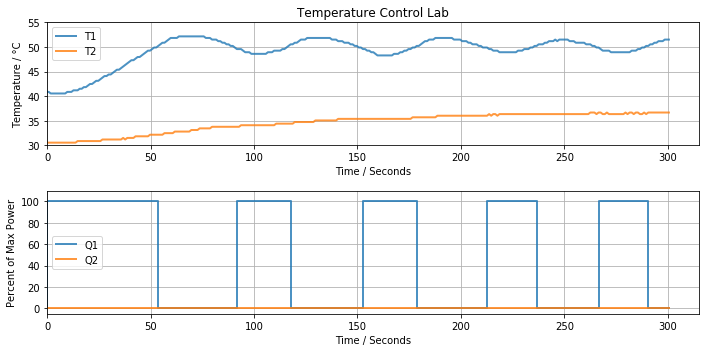

TCLab disconnected successfully.


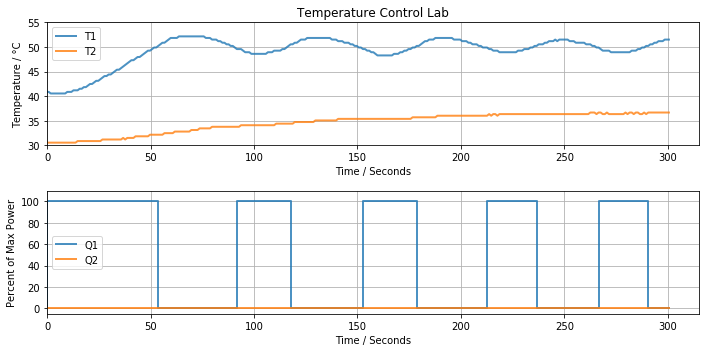

In [2]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup



# control parameters
Qmax = 100
Tsetpoint = 50
d = 0.5

# time horizon and time step
tfinal = 300
tstep = 1

# perform experiment
with TCLab() as a:
    h = Historian(a)
    h.initplot(tfinal)
    Q1 = a.Q1()
    for t in clock(tfinal, tstep):
        T1 = a.T1
        if T1 <= Tsetpoint - d/2:
            Q1 = Qmax
        if T1 >= Tsetpoint + d/2:
            Q1 = 0
        a.Q1(Q1)
        h.update()

## 3.2.3 Multivariable On-Off Control

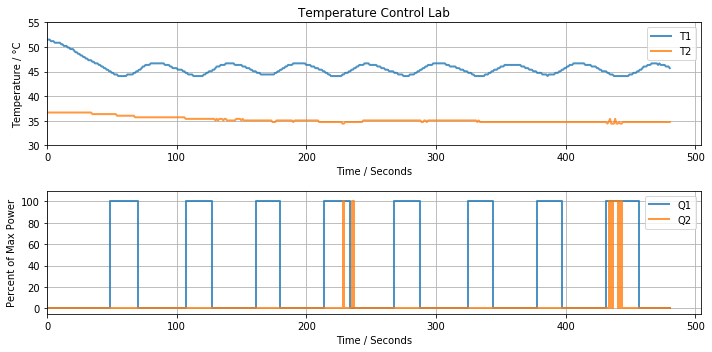

TCLab disconnected successfully.


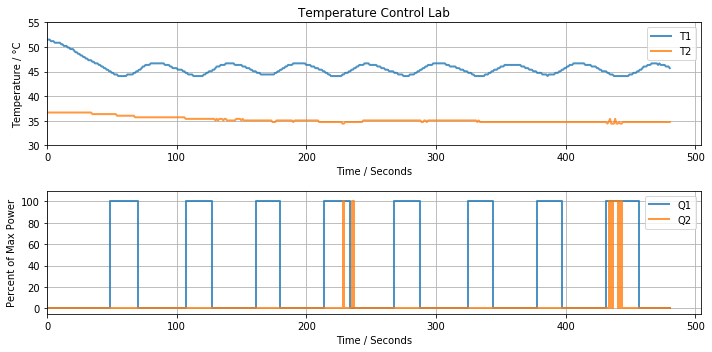

In [3]:
%matplotlib inline
from tclab import TCLab, clock, Historian

Tsetpoint1 = 45
Tsetpoint2 = 35
Qmax = 100
tfinal = 480
d = 0.5

with TCLab() as a:
    h = Historian(a)
    h.initplot(tfinal)
    Q1 = a.Q1()
    Q2 = a.Q2()
    for t in clock(tfinal):
        T1 = a.T1
        if T1 <= Tsetpoint1 - d/2:
            Q1 = Qmax
        if T1 >= Tsetpoint1 + d/2:
            Q1 = 0
        a.Q1(Q1)

        T2 = a.T2
        if T2 <= Tsetpoint2 - d/2:
            Q2 = Qmax
        if T2 >= Tsetpoint2 + d/2:
            Q2 = 0
        a.Q2(Q2)
        h.update()

## 3.2.4 Exercises

1. Examining the closed-loop responses, it's obvious that the heater is oversized for the purpose of control at 40 deg C.  Try other values for $Q^{\max}$ to see if you can improve closed-loop performance.

2. What is the effect of sample time on control performance? What happens if you make the controller sample time longer?

3. In a new cell, create a modification of the script to include a change in setpoint from 40 deg C to 50 deg C at the 300 second mark. Run the experiment for at least 10 minutes to see the full effect.

4. For a relay control with hystersis, try to sketch a graph of $Q$ as a function of $T$ assuming $T_{Setpoint} = 50$ and $h = 3$. Can you draw a unique function? Why not?

<!--NAVIGATION-->
< [3.1 Case Study: Thermal Cycling for PCR](https://jckantor.github.io/cbe30338-2021/03.01-Case-Study-Thermal-Cycling-PCR.html) | [Contents](toc.html) | [3.3 PID Control](https://jckantor.github.io/cbe30338-2021/03.03-PID_Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.02-Relay-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.02-Relay-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>